# License detector pipeline visualization

In [987]:
import matplotlib
import importlib

from notebooks.utils import git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

%cd {git_root()}

/home/ogurczak/ws/twm-proj


/home/ogurczak/.cache/pypoetry/virtualenvs/twm-proj-bI3UNY_C-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [988]:
import glob
from pathlib import Path

DATASET_PATH = Path("datasets/01-polish-licence-plates/train")
filenames = glob.glob("*.jpg", root_dir=DATASET_PATH)
to_filter = {
    2: "hard",
    3: "black",
}
filenames = [filename for i, filename in enumerate(filenames) if i not in to_filter]
path = DATASET_PATH / filenames[0]

path

PosixPath('datasets/01-polish-licence-plates/train/knmnkmas_jpg.rf.5edecba9161c52e72bc43194d175de42.jpg')

## Image loading

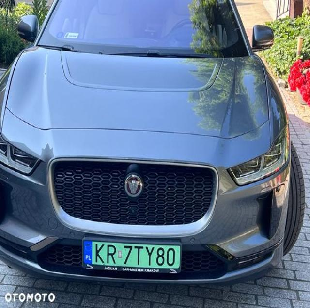

In [989]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

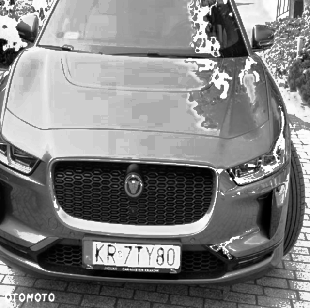

In [990]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

## Edge filter

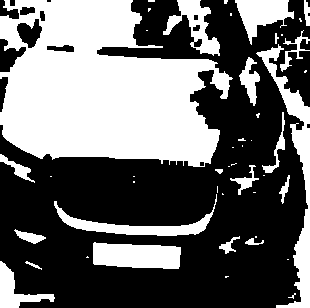

In [991]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 54
example contour:
 [[608 609]
 [608 611]
 [610 611]
 [610 609]]


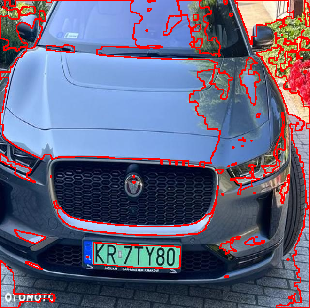

In [992]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 3
example rect:
 [[  0 542]
 [  0 639]
 [ 29 610]
 [111 625]]


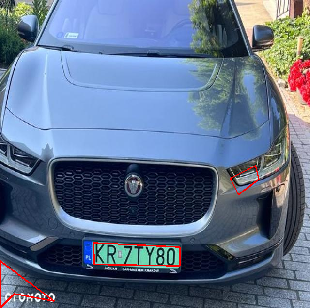

In [993]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

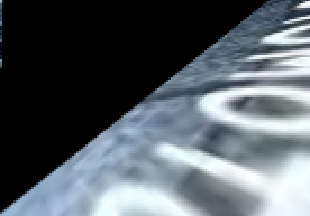

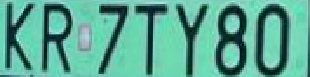

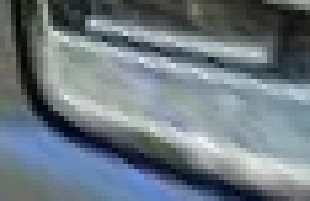

In [994]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
for rect_image in rect_images:
    show(rect_image)

## Rectangle classification

In [995]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('TWO_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.6881046788263282,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.001791448369105923,
   <RectangleType.MINI_PLATE: 3>: 0.4851251840942562}),
 ('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.13282051282051277,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.7753734061930784,
   <RectangleType.MINI_PLATE: 3>: 0.4315343915343916}),
 ('TWO_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.6653846153846155,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.07092320966350309,
   <RectangleType.MINI_PLATE: 3>: 0.4476190476190476})]

## Pre-OCR processing

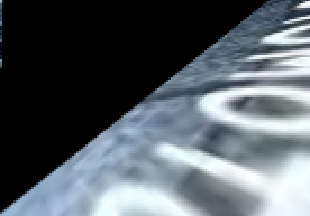

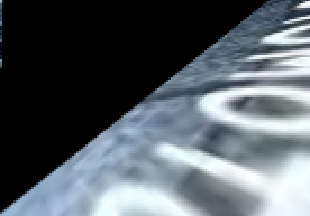

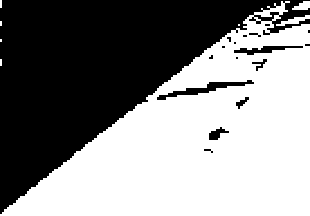

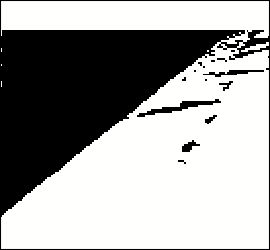

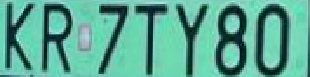

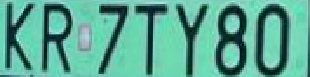

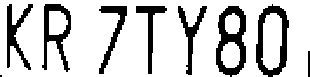

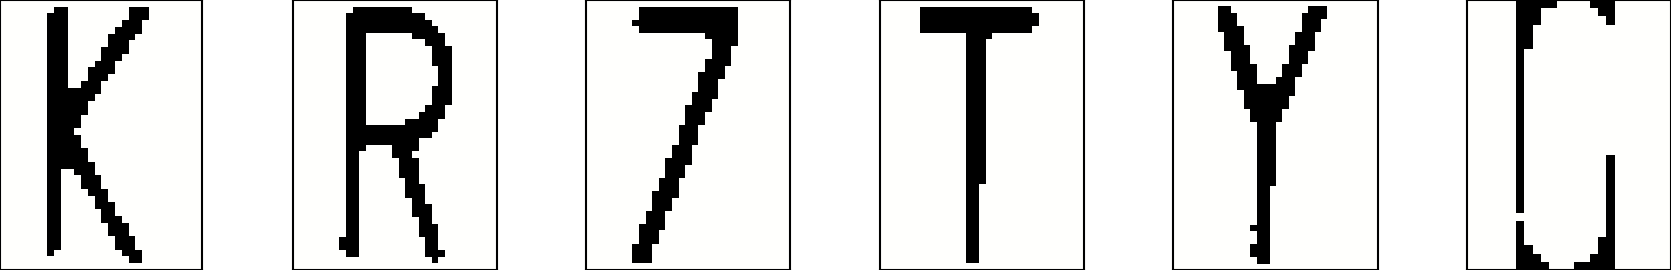

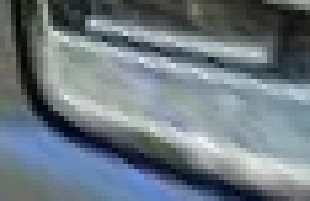

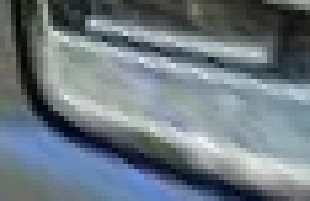

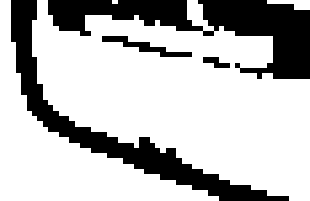

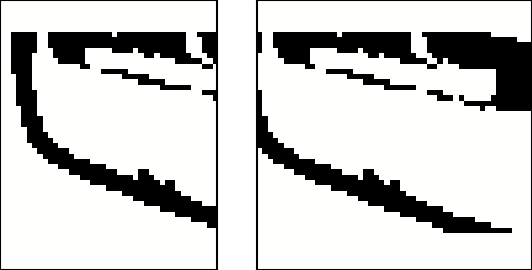

In [996]:
from notebooks.utils import show_collage
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate in plates:
    show(plate)
    plate = pre_ocr.PreOcr().cut(plate)
    show(plate)
    plate = pre_ocr.PreOcr().to_grayscale(plate)
    show(plate)

    letters = [*pre_ocr.PreOcr().get_letters(plate)]
    show_collage(letters, col_wrap=len(letters))

    plate_letters.append(letters)

## OCR

In [997]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

A
KR7TYA
CC
